In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def load_metrics(base_path):
    """Load test performance metrics from all timestamp directories."""
    data = []

    for dir_name in sorted(os.listdir(base_path), key=lambda x: int(x.split("_")[-1])):  # Sort by index
        dir_path = os.path.join(base_path, dir_name)
        file_path = os.path.join(f"{dir_path}/lightning_logs", "metrics.csv")
        print(file_path)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, header=None)
            df.columns = ["epoch", "gpu_memory_allocated_MB", "gpu_memory_reserved_MB", "step",
                          "test_au_roc", "test_avg_pr", "test_loss", "time_sec",
                          "train_au_roc", "train_avg_pr", "train_loss",
                          "val_au_roc", "val_avg_pr", "val_loss"]

            # Get last epoch's test metrics
            latest_metrics = df.iloc[-1]
            data.append({
                "timestamp": int(dir_name.split("_")[-1]),
                "test_au_roc": float(latest_metrics["test_au_roc"]),
                "test_avg_pr": float(latest_metrics["test_avg_pr"]),
                "test_loss": float(latest_metrics["test_loss"])
            })
    return pd.DataFrame(data).sort_values("timestamp")


In [4]:
def load_epoch_metrics(base_path):
    """Load all training and validation metrics for each index directory over epochs."""
    metrics = []

    for dir_name in sorted(os.listdir(base_path), key=lambda x: int(x.split("_")[-1])):  # Sort directories by index
        dir_path = os.path.join(base_path, dir_name)
        file_path = os.path.join(f"{dir_path}/lightning_logs", "metrics.csv")

        if os.path.exists(file_path):
            df = pd.read_csv(file_path, header=None).iloc[1:].reset_index(drop=True)
            df.columns = ["epoch", "gpu_memory_allocated_MB", "gpu_memory_reserved_MB", "step",
                          "test_au_roc", "test_avg_pr", "test_loss", "time_sec",
                          "train_au_roc", "train_avg_pr", "train_loss",
                          "val_au_roc", "val_avg_pr", "val_loss"]
            df = df[["epoch", "train_loss", "val_loss", "train_au_roc", "val_au_roc"]]
            train_df = df[["epoch", "train_loss", "train_au_roc"]].dropna()
            val_df = df[["epoch", "val_loss", "val_au_roc"]].dropna()
            merged_df = pd.merge(val_df, train_df, on="epoch", how='inner')
            merged_df["index"] = int(dir_name.split("_")[-1])  # Add index number
            merged_df['epoch'] = merged_df['epoch'].astype(int)
            merged_df[['train_loss', 'val_loss', 'train_au_roc', 'val_au_roc']] = merged_df[['train_loss', 'val_loss', 'train_au_roc', 'val_au_roc']].astype(float)
            metrics.append(merged_df[["index", "epoch", "train_loss", "val_loss", "train_au_roc", "val_au_roc"]])

    return pd.concat(metrics)

In [5]:
memory_false_path = "/home/vahid/Projects/pythonProject/DyFraudNet/experiments/experiments/dyfraudnet/node_level/DGraphFin/7_days/False_GIN/2025-03-20_11:05:42"
memory_true_path = "/home/vahid/Projects/pythonProject/DyFraudNet/experiments/experiments/dyfraudnet/node_level/DGraphFin/7_days/True_GIN/2025-03-20_11:51:17"
df_model_memory_false = load_metrics(memory_false_path)
df_model_memory_true = load_metrics(memory_true_path)
df_model_memory_true = df_model_memory_true.sort_values("timestamp")
df_model_memory_false = df_model_memory_false.sort_values("timestamp")

/home/vahid/Projects/pythonProject/DyFraudNet/experiments/experiments/dyfraudnet/node_level/DGraphFin/7_days/False_GIN/2025-03-20_11:05:42/index_0/lightning_logs/metrics.csv
/home/vahid/Projects/pythonProject/DyFraudNet/experiments/experiments/dyfraudnet/node_level/DGraphFin/7_days/False_GIN/2025-03-20_11:05:42/index_1/lightning_logs/metrics.csv
/home/vahid/Projects/pythonProject/DyFraudNet/experiments/experiments/dyfraudnet/node_level/DGraphFin/7_days/False_GIN/2025-03-20_11:05:42/index_2/lightning_logs/metrics.csv
/home/vahid/Projects/pythonProject/DyFraudNet/experiments/experiments/dyfraudnet/node_level/DGraphFin/7_days/False_GIN/2025-03-20_11:05:42/index_3/lightning_logs/metrics.csv
/home/vahid/Projects/pythonProject/DyFraudNet/experiments/experiments/dyfraudnet/node_level/DGraphFin/7_days/False_GIN/2025-03-20_11:05:42/index_4/lightning_logs/metrics.csv
/home/vahid/Projects/pythonProject/DyFraudNet/experiments/experiments/dyfraudnet/node_level/DGraphFin/7_days/False_GIN/2025-03-20_

In [6]:
df_model_memory_true.dtypes

timestamp        int64
test_au_roc    float64
test_avg_pr    float64
test_loss      float64
dtype: object

<Figure size 1200x500 with 0 Axes>

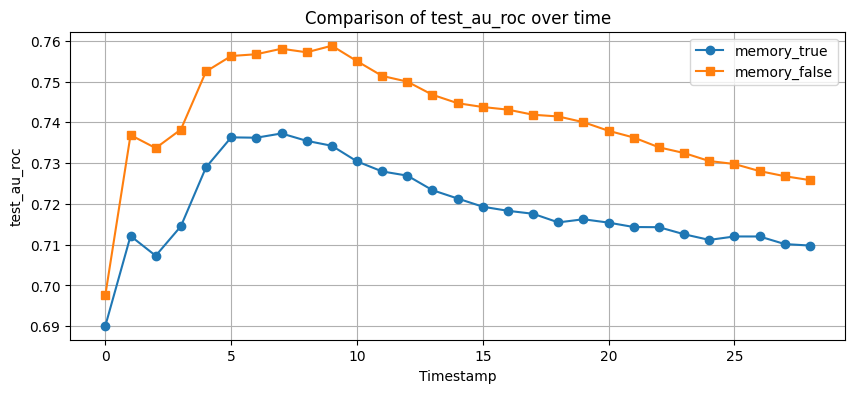

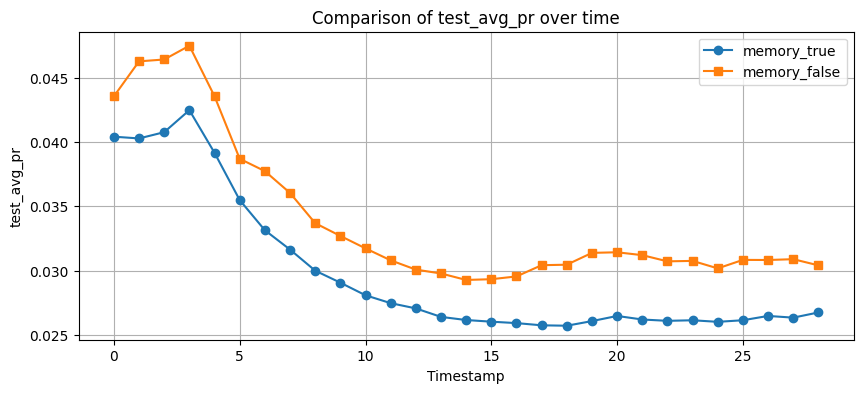

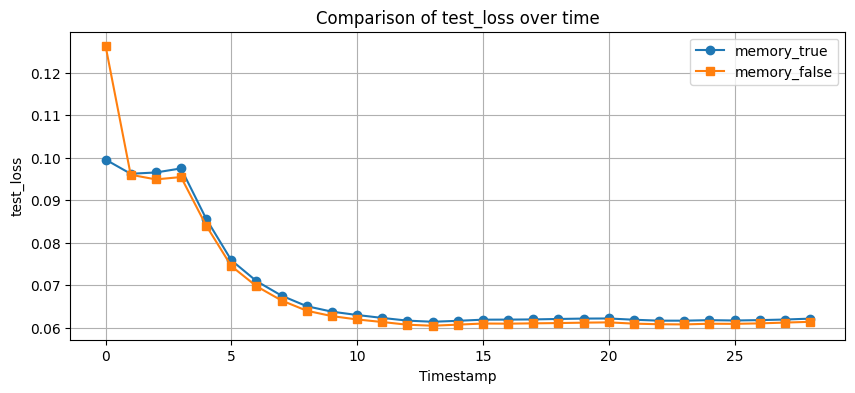

In [7]:
plt.figure(figsize=(12, 5))

for metric in ["test_au_roc", "test_avg_pr", "test_loss"]:
    plt.figure(figsize=(10, 4))
    plt.plot(df_model_memory_true["timestamp"], df_model_memory_true[metric], label="memory_true", marker="o")
    plt.plot(df_model_memory_false["timestamp"], df_model_memory_false[metric], label="memory_false", marker="s")
    plt.xlabel("Timestamp")
    plt.ylabel(metric)
    plt.title(f"Comparison of {metric} over time")
    plt.legend()
    plt.grid()
    plt.show()

In [8]:
df_model_training_memory_true = load_epoch_metrics(memory_true_path)
df_model2_training_memory_false = load_epoch_metrics(memory_false_path)

In [9]:
df_model2_training_memory_false.dtypes

index             int64
epoch             int64
train_loss      float64
val_loss        float64
train_au_roc    float64
val_au_roc      float64
dtype: object

29


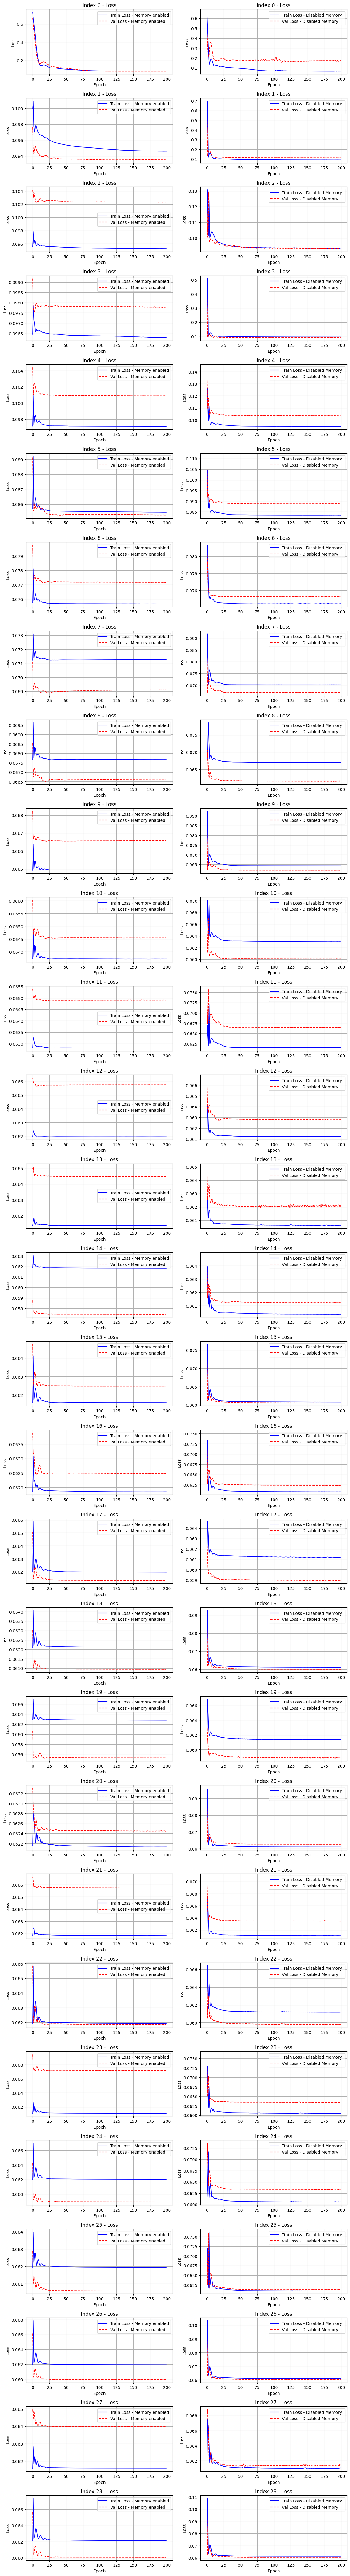

In [10]:
indices = sorted(df_model_training_memory_true["index"].unique())
num_rows = len(indices)
print(num_rows)
fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 3))

# Plot each index separately
for i, index in enumerate(indices):
    ax1, ax2 = axes[i] if num_rows > 1 else (axes[0], axes[1])  # Handle single row case

    df1_subset = df_model_training_memory_true[df_model_training_memory_true["index"] == index]
    df2_subset = df_model2_training_memory_false[df_model2_training_memory_false["index"] == index]

    # Plot Training & Validation Loss
    ax1.plot(df1_subset["epoch"], df1_subset["train_loss"], label="Train Loss - Memory enabled", linestyle="-", color="blue")
    ax1.plot(df1_subset["epoch"], df1_subset["val_loss"], label="Val Loss - Memory enabled", linestyle="--", color="red")
    ax1.set_title(f"Index {index} - Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid()

    ax2.plot(df2_subset["epoch"], df2_subset["train_loss"], label="Train Loss - Disabled Memory ", linestyle="-", color="blue")
    ax2.plot(df2_subset["epoch"], df2_subset["val_loss"], label="Val Loss - Disabled Memory", linestyle="--", color="red")
    ax2.set_title(f"Index {index} - Loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid()

# Adjust layout
plt.tight_layout()
plt.show()

29


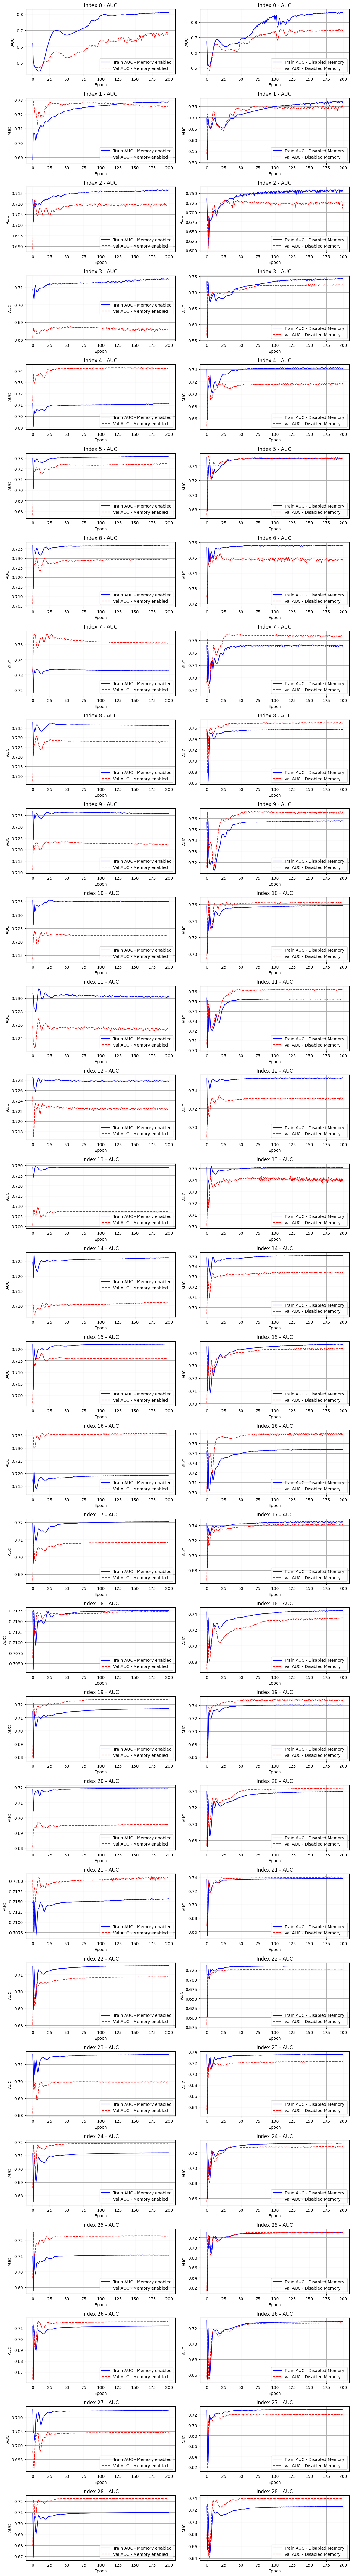

In [11]:
indices = sorted(df_model_training_memory_true["index"].unique())
num_rows = len(indices)
print(num_rows)
fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 3))

# Plot each index separately
for i, index in enumerate(indices):
    ax1, ax2 = axes[i] if num_rows > 1 else (axes[0], axes[1])  # Handle single row case

    df1_subset = df_model_training_memory_true[df_model_training_memory_true["index"] == index]
    df2_subset = df_model2_training_memory_false[df_model2_training_memory_false["index"] == index]

    # Plot Training & Validation Loss
    ax1.plot(df1_subset["epoch"], df1_subset["train_au_roc"], label="Train AUC - Memory enabled", linestyle="-", color="blue")
    ax1.plot(df1_subset["epoch"], df1_subset["val_au_roc"], label="Val AUC - Memory enabled", linestyle="--", color="red")
    ax1.set_title(f"Index {index} - AUC")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("AUC")
    ax1.legend()
    ax1.grid()

    ax2.plot(df2_subset["epoch"], df2_subset["train_au_roc"], label="Train AUC - Disabled Memory ", linestyle="-", color="blue")
    ax2.plot(df2_subset["epoch"], df2_subset["val_au_roc"], label="Val AUC - Disabled Memory", linestyle="--", color="red")
    ax2.set_title(f"Index {index} - AUC")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("AUC")
    ax2.legend()
    ax2.grid()

# Adjust layout
plt.tight_layout()
plt.show()